In [1]:
import torch
from build_vocab import WordVocab
from pretrain_trfm import TrfmSeq2seq
from utils import split
# build_vocab, pretrain_trfm, utils packages are from SMILES Transformer
from transformers import T5EncoderModel, T5Tokenizer
# transformers package is from ProtTrans
import re
import gc
import numpy as np
import pandas as pd
import pickle
import math
from tqdm import tqdm

/home/wuke/anaconda3/envs/UniKP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def smiles_to_vec(Smiles):
    pad_index = 0
    unk_index = 1
    eos_index = 2
    sos_index = 3
    mask_index = 4
    vocab = WordVocab.load_vocab('vocab.pkl')
    def get_inputs(sm):
        seq_len = 220
        sm = sm.split()
        if len(sm)>218:
            print('SMILES is too long ({:d})'.format(len(sm)))
            sm = sm[:109]+sm[-109:]
        ids = [vocab.stoi.get(token, unk_index) for token in sm]
        ids = [sos_index] + ids + [eos_index]
        seg = [1]*len(ids)
        padding = [pad_index]*(seq_len - len(ids))
        ids.extend(padding), seg.extend(padding)
        return ids, seg
    def get_array(smiles):
        x_id, x_seg = [], []
        for sm in smiles:
            a,b = get_inputs(sm)
            x_id.append(a)
            x_seg.append(b)
        return torch.tensor(x_id), torch.tensor(x_seg)
    trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
    trfm.load_state_dict(torch.load('trfm_12_23000.pkl'))
    trfm.eval()
    x_split = [split(sm) for sm in Smiles]
    xid, xseg = get_array(x_split)
    X = trfm.encode(torch.t(xid))
    return X


def Seq_to_vec(Sequence):
    for i in range(len(Sequence)):
        if len(Sequence[i]) > 1000:
            Sequence[i] = Sequence[i][:500] + Sequence[i][-500:]
    sequences_Example = []
    for i in range(len(Sequence)):
        zj = ''
        for j in range(len(Sequence[i]) - 1):
            zj += Sequence[i][j] + ' '
        zj += Sequence[i][-1]
        sequences_Example.append(zj)
    ###### you should place downloaded model into this directory.
    tokenizer = T5Tokenizer.from_pretrained("./prot_t5_xl_uniref50", do_lower_case=False)
    model = T5EncoderModel.from_pretrained("./prot_t5_xl_uniref50")
    gc.collect()
    # print(torch.cuda.is_available())
    # 'cuda:0' if torch.cuda.is_available() else
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model = model.eval()
    features = []
    for i in tqdm(range(len(sequences_Example))):
        # print('For sequence ', str(i+1))
        sequences_Example_i = sequences_Example[i]
        sequences_Example_i = [re.sub(r"[UZOB]", "X", sequences_Example_i)]
        ids = tokenizer.batch_encode_plus(sequences_Example_i, add_special_tokens=True, padding=True)
        input_ids = torch.tensor(ids['input_ids']).to(device)
        attention_mask = torch.tensor(ids['attention_mask']).to(device)
        with torch.no_grad():
            embedding = model(input_ids=input_ids, attention_mask=attention_mask)
        embedding = embedding.last_hidden_state.cpu().numpy()
        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][:seq_len - 1]
            features.append(seq_emd)
    features_normalize = np.zeros([len(features), len(features[0][0])], dtype=float)
    for i in range(len(features)):
        for k in range(len(features[0][0])):
            for j in range(len(features[i])):
                features_normalize[i][k] += features[i][j][k]
            features_normalize[i][k] /= len(features[i])
    return features_normalize


In [3]:
# sequences = ['MEDIPDTSRPPLKYVKGIPLIKYFAEALESLQDFQAQPDDLLISTYPKSGTTWVSEILDMIYQDGDVEKCRRAPVFIRVPFLEFKA',
#                 'PGIPTGLEVLKDTPAPRLIKTHLPLALLPQTLLDQKVKVVYVARNAKDVAVSYYHFYRMAKVHPDPDTWDSFLEKFMAGEVSYGSW',
#                 'YQHVQEWWELSHTHPVLYLFYEDMKENPKREIQKILKFVGRSLPEETVDLIVQHTSFKEMKNNSMANYTTLSPDIMDHSISAFMRK',
#                 'GISGDWKTTFTVAQNERFDADYAKKMEGCGLSFRTQL']
# Smiles = ['OC1=CC=C(C[C@@H](C(O)=O)N)C=C1','OC1=CC=C(C[C@@H](C(O)=O)N)C=C1','OC1=CC=C(C[C@@H](C(O)=O)N)C=C1','OC1=CC=C(C[C@@H](C(O)=O)N)C=C1']
# seq_vec = Seq_to_vec(sequences)
# smiles_vec = smiles_to_vec(Smiles)
# fused_vector = np.concatenate((smiles_vec, seq_vec), axis=1)

# ###### you should place downloaded model into this directory.
# # For kcat
# # with open('./unikp_model/UniKP for kcat.pkl', "rb") as f:
# #     model = pickle.load(f)
# # For Km
# with open('./unikp_model/UniKP for Km.pkl', "rb") as f:
#     model = pickle.load(f)
# # For kcat/Km
# # with open('./unikp_model/UniKP for kcat_Km.pkl', "rb") as f:
# #     model = pickle.load(f)

# Pre_label = model.predict(fused_vector)
# Pre_label_pow = [math.pow(10, Pre_label[i]) for i in range(len(Pre_label))]
# print(len(Pre_label_pow))
# res = pd.DataFrame({'sequences': sequences, 'Smiles': Smiles, 'Pre_label': Pre_label_pow})
# # res.to_excel('Kinetic_parameters_predicted_label.xlsx')
# res

In [4]:
yeast8U_sequence_smiles_pre_path = '../Final-AIGEM-new/Data/kcat_km_predict/yeast8U_sequence_smiles_prepare_lipids.csv'

In [5]:
KM_pre_df = pd.read_csv(yeast8U_sequence_smiles_pre_path)
KM_pre_df = KM_pre_df[['id','gene','sub','Sequence']]
print(KM_pre_df.shape)
KM_pre_df.head()

(326775, 4)


,id,gene,sub,Sequence
0,rxnl538155_2,YPL227C,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MRALRFLIENRNTVFFTLLVALVLSLYLLVYLFSHTPRPPYPEELK...
1,rxnl538155_4,YDR373W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MGAKTSKLSKDDLTCLKQSTYFDRREIQQWHKGFLRDCPSGQLARE...
2,rxnl538155_6,YGL186C,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MNRDNMDTTKRKEDHTKHTTDVIEFYEEGTAASSLNIATEKANSSP...
3,rxnl538155_8,YLR350W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MIDRTKNESPAFEESPLTPNVSNLKPFPSQSNKISTPVTDHRRRRS...
4,rxnl538155_10,YGR227W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MDAKKNTGEANNDVLEEEAAIQLIAPGIARNLTQEVITGIFCNVVI...


In [6]:
smiles_list = list(set(KM_pre_df['sub'].to_list()))
enzyme_list = list(set(KM_pre_df['Sequence'].to_list()))
print(len(smiles_list))
print(len(enzyme_list))

134
971


In [7]:
smiles_vec = smiles_to_vec(smiles_list)
smiles_vec_dict = {}
for i in range(len(smiles_list)):
    smiles_vec_dict[smiles_list[i]] = smiles_vec[i]
smiles_vec_dict

There are 134 molecules. It will take a little time.


{'CCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O': array([-0.02848044,  0.25918758, -0.41107306, ...,  0.3770766 ,
         0.9385793 ,  0.97611135], dtype=float32),
 'CCCO': array([ 0.03447651, -0.0498111 ,  0.36385104, ...,  1.096107  ,
         0.63953924,  0.82599485], dtype=float32),
 'CCCCCCCCCCCCCCCCCCCCCCCC(CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O)O': array([-0.0314245 ,  0.2877853 , -0.3555208 , ...,  0.46587247,
         0.9527976 ,  0.9725501 ], dtype=float32),
 'CCCCCCCCC=CCCCCCCCC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=C(N=CN=C32)N)O)OP(=O)(O)O)O': array([-0.0485763 ,  0.258169  , -0.40094754, ...,  0.38323194,
         0.9958566 ,  0.9106983 ], dtype=float32),
 'CC(C)CC=O': array([-0.00446483, -0.03938913,  0.28621486, ...,  1.3492028 ,
         0.8126566 ,  0.14624166], dtype=float32),
 'C(C1C(C(C(C(O1)OC2C(OC(C(C2O)O)O

In [8]:
enzyme_vec = Seq_to_vec(enzyme_list)
enzyme_vec_dict = {}
for i in range(len(enzyme_list)):
    enzyme_vec_dict[enzyme_list[i]] = enzyme_vec[i]
enzyme_vec_dict

Some weights of the model checkpoint at ./prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.6.layer.0.SelfAttention.q.weight', 'decoder.block.6.layer.1.EncDecAttention.o.weight', 'decoder.block.19.layer.1.EncDecAttention.q.weight', 'decoder.block.5.layer.0.SelfAttention.v.weight', 'decoder.block.11.layer.0.layer_norm.weight', 'decoder.block.9.layer.2.layer_norm.weight', 'decoder.block.21.layer.1.EncDecAttention.v.weight', 'decoder.block.23.layer.2.layer_norm.weight', 'decoder.block.12.layer.2.DenseReluDense.wo.weight', 'decoder.block.4.layer.0.SelfAttention.o.weight', 'decoder.block.22.layer.0.SelfAttention.o.weight', 'decoder.block.4.layer.0.SelfAttention.v.weight', 'decoder.block.20.layer.0.SelfAttention.v.weight', 'decoder.block.7.layer.2.DenseReluDense.wi.weight', 'decoder.block.13.layer.1.EncDecAttention.k.weight', 'decoder.block.6.layer.0.SelfAttention.k.weight', 'decoder.block.19.layer.1.layer_norm.weight', 'decoder.block.11.layer.0.SelfAttentio

{'MSEEKTYKRVEQDDPVPELDIKQGPVRPFIVTDPSAELASLRTMVTLKEKLLVACLAVFTAVIRLHGLAWPDSVVFDEVHFGGFASQYIRGTYFMDVHPPLAKMLYAGVASLGGFQGDFDFENIGDSFPSTTPYVLMRFFSASLGALTVILMYMTLRYSGVRMWVALMSAICFAVENSYVTISRYILLDAPLMFFIAAAVYSFKKYEMYPANSLNAYKSLLATGIALGMASSSKWVGLFTVTWVGLLCIWRLWFMIGDLTKSSKSIFKVAFAKLAFLLGVPFALYLVFFYIHFQSLTLDGDGASFFSPEFRSTLKNNKIPQNVVADVGIGSIISLRHLSTMGGYLHSHSHNYPAGSEQQQSTLYPHMDANNDWLLELYNAPGESLTTFQNLTDGTKVRLFHTVTRCRLHSHDHKPPVSESSDWQKEVSCYGYSGFDGDANDDWVVEIDKKNSAPGVAQERVIALDTKFRLRHAMTGCYLFSHEVKLPAWGFEQQEVTCASSGRHDLTLWYVENNSNPLLPEDTKRISYKPASFISKFIESHKKMWHINKNLVEPHVYESQPTSWPFLLRGISYWGENNRNVYLLGNAIVWWAVTAFIGIFGLIVITELFSWQLGKPILKDSKVVNFHVQVIHYLLGFAVHYAPSFLMQRQMFLHHYLPAYYFGILALGHALDIIVSYVFRSKRQMGYAVVITFLAASVYFFKSFSPIIYGTPWTQELCQKSQWLSGWDYNCNTYFSSLEEYKNQTLTKRESQPAATSTVEEITIEGDGPSYEDLMNEDGKKIFKDTEGNELDPEVVKKMLEEEGANILKVEKRAVLE': array([-0.01659201, -0.02178906,  0.04627492, ...,  0.00902195,
         0.02306665,  0.00441293]),
 'MVFTKEEVDYSLYLVTDSTMLPPGTTLCSQVEAGLKNGVTLVQIREKDIETKNFVAEALEVQKICKKYNVPLIIND

In [9]:
KM_pre_df['enzyme_vec'] = KM_pre_df['Sequence'].apply(lambda x: enzyme_vec_dict[x] if x in enzyme_vec_dict.keys() else '')
print(KM_pre_df.shape)
KM_pre_df = KM_pre_df[KM_pre_df['enzyme_vec']!='']
print(KM_pre_df.shape)
KM_pre_df.head()

(326775, 5)
(302664, 5)


/home/wuke/anaconda3/envs/UniKP/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,id,gene,sub,Sequence,enzyme_vec
0,rxnl538155_2,YPL227C,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MRALRFLIENRNTVFFTLLVALVLSLYLLVYLFSHTPRPPYPEELK...,"[0.022261996821132293, -0.03952951655684117, 0..."
1,rxnl538155_4,YDR373W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MGAKTSKLSKDDLTCLKQSTYFDRREIQQWHKGFLRDCPSGQLARE...,"[0.01803948650148844, 0.0526232724846379, -0.0..."
2,rxnl538155_6,YGL186C,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MNRDNMDTTKRKEDHTKHTTDVIEFYEEGTAASSLNIATEKANSSP...,"[-0.009821652282762867, 0.030654681574323335, ..."
3,rxnl538155_8,YLR350W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MIDRTKNESPAFEESPLTPNVSNLKPFPSQSNKISTPVTDHRRRRS...,"[0.028962701317612773, -0.0069587818015756295,..."
4,rxnl538155_10,YGR227W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MDAKKNTGEANNDVLEEEAAIQLIAPGIARNLTQEVITGIFCNVVI...,"[0.006944533046889341, -0.023517403145669958, ..."


In [10]:
KM_pre_df['smiles_vec'] = KM_pre_df['sub'].apply(lambda x: smiles_vec_dict[x] if x in smiles_vec_dict.keys() else '')
print(KM_pre_df.shape)
KM_pre_df = KM_pre_df[KM_pre_df['smiles_vec']!='']
print(KM_pre_df.shape)
KM_pre_df.head()

/home/wuke/anaconda3/envs/UniKP/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


(302664, 6)
(302664, 6)


,id,gene,sub,Sequence,enzyme_vec,smiles_vec
0,rxnl538155_2,YPL227C,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MRALRFLIENRNTVFFTLLVALVLSLYLLVYLFSHTPRPPYPEELK...,"[0.022261996821132293, -0.03952951655684117, 0...","[0.052943278, 0.25028747, -0.03450262, 0.26732..."
1,rxnl538155_4,YDR373W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MGAKTSKLSKDDLTCLKQSTYFDRREIQQWHKGFLRDCPSGQLARE...,"[0.01803948650148844, 0.0526232724846379, -0.0...","[0.052943278, 0.25028747, -0.03450262, 0.26732..."
2,rxnl538155_6,YGL186C,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MNRDNMDTTKRKEDHTKHTTDVIEFYEEGTAASSLNIATEKANSSP...,"[-0.009821652282762867, 0.030654681574323335, ...","[0.052943278, 0.25028747, -0.03450262, 0.26732..."
3,rxnl538155_8,YLR350W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MIDRTKNESPAFEESPLTPNVSNLKPFPSQSNKISTPVTDHRRRRS...,"[0.028962701317612773, -0.0069587818015756295,...","[0.052943278, 0.25028747, -0.03450262, 0.26732..."
4,rxnl538155_10,YGR227W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MDAKKNTGEANNDVLEEEAAIQLIAPGIARNLTQEVITGIFCNVVI...,"[0.006944533046889341, -0.023517403145669958, ...","[0.052943278, 0.25028747, -0.03450262, 0.26732..."


In [11]:
KM_pre_df_enzyme_vec = KM_pre_df['enzyme_vec'].to_list()
KM_pre_df_smiles_vec = KM_pre_df['smiles_vec'].to_list()

In [12]:
fused_vector = np.concatenate((KM_pre_df_smiles_vec, KM_pre_df_enzyme_vec), axis=1)

In [13]:
with open('./unikp_model/UniKP for Km.pkl', "rb") as f:
    model = pickle.load(f)
Pre_label = model.predict(fused_vector)
Pre_label_pow = [math.pow(10, Pre_label[i]) for i in range(len(Pre_label))]
KM_pre_df['km'] = Pre_label_pow
# print(len(Pre_label_pow))
# res = pd.DataFrame('Pre_label': Pre_label_pow})
# res.to_csv('./result/yeast8U_unikp_km.csv', index=False)

/home/wuke/anaconda3/envs/UniKP/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator ExtraTreeRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/wuke/anaconda3/envs/UniKP/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator ExtraTreesRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [14]:
KM_pre_df

,id,gene,sub,Sequence,enzyme_vec,smiles_vec,km
0,rxnl538155_2,YPL227C,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MRALRFLIENRNTVFFTLLVALVLSLYLLVYLFSHTPRPPYPEELK...,"[0.022261996821132293, -0.03952951655684117, 0...","[0.052943278, 0.25028747, -0.03450262, 0.26732...",0.086924
1,rxnl538155_4,YDR373W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MGAKTSKLSKDDLTCLKQSTYFDRREIQQWHKGFLRDCPSGQLARE...,"[0.01803948650148844, 0.0526232724846379, -0.0...","[0.052943278, 0.25028747, -0.03450262, 0.26732...",0.051844
2,rxnl538155_6,YGL186C,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MNRDNMDTTKRKEDHTKHTTDVIEFYEEGTAASSLNIATEKANSSP...,"[-0.009821652282762867, 0.030654681574323335, ...","[0.052943278, 0.25028747, -0.03450262, 0.26732...",0.104408
3,rxnl538155_8,YLR350W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MIDRTKNESPAFEESPLTPNVSNLKPFPSQSNKISTPVTDHRRRRS...,"[0.028962701317612773, -0.0069587818015756295,...","[0.052943278, 0.25028747, -0.03450262, 0.26732...",0.083438
4,rxnl538155_10,YGR227W,C(C1C(C(C(C(O1)OP(=O)(O)O)O)O)O)O,MDAKKNTGEANNDVLEEEAAIQLIAPGIARNLTQEVITGIFCNVVI...,"[0.006944533046889341, -0.023517403145669958, ...","[0.052943278, 0.25028747, -0.03450262, 0.26732...",0.085906
...,...,...,...,...,...,...,...
326770,rxnl9753_254,YMR125W,CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=...,MFNRKRRGDFDEDENYRDFRPRMPKRQRIPPVVQLCKEMMPDIRTI...,"[-0.03879543584117041, -0.14412898639779895, 0...","[-0.054330684, 0.21531932, -0.47081304, 0.3772...",0.053541
326771,rxnl9753_255,YCR048W,C(CC(=O)C(=O)O)CC(=O)O,MTETKDLLQDEEFLKIRRLNSAEANKRHSVTYDNVILPQESMEVSP...,"[0.015354327528937157, -0.022977386553462625, ...","[0.03627911, 0.09731042, 0.12563092, 0.3172112...",0.235667
326772,rxnl9753_256,YCR048W,CC(C)(COP(=O)(O)OP(=O)(O)OCC1C(C(C(O1)N2C=NC3=...,MTETKDLLQDEEFLKIRRLNSAEANKRHSVTYDNVILPQESMEVSP...,"[0.015354327528937157, -0.022977386553462625, ...","[-0.054330684, 0.21531932, -0.47081304, 0.3772...",0.065280
326773,rxnl9753_257,YMR069W,C(CC(=O)C(=O)O)CC(=O)O,MRSSVYSENTYNCIRTSKEHLTERRRVAMAPMFQHFLNLCVEKFPE...,"[0.07614139511266299, -0.038628685422723685, -...","[0.03627911, 0.09731042, 0.12563092, 0.3172112...",0.343561


In [15]:
with open('./unikp_model/UniKP for kcat.pkl', "rb") as f:
    model = pickle.load(f)
Pre_label = model.predict(fused_vector)
Pre_label_pow = [math.pow(10, Pre_label[i]) for i in range(len(Pre_label))]
KM_pre_df['kcat'] = Pre_label_pow
# print(len(Pre_label_pow))
KM_pre_df.to_csv('./result/yeast8U_unikp_lipids.csv')

/home/wuke/anaconda3/envs/UniKP/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator ExtraTreeRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/home/wuke/anaconda3/envs/UniKP/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator ExtraTreesRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [2]:
KM_pre_df = pd.read_csv('./result/yeast8U_unikp_lipids.csv')

In [3]:
KM_pre_df_yeast8U = pd.read_csv('./result/yeast8U_unikp.csv')

# kcat

In [10]:
print(KM_pre_df_yeast8U.shape)
KM_pre_df_yeast8U = pd.concat([KM_pre_df_yeast8U[KM_pre_df_yeast8U['id'].str.contains('r_')].drop_duplicates(subset=['gene', 'sub']),
                       KM_pre_df_yeast8U[~KM_pre_df_yeast8U['id'].str.contains('r_')].drop_duplicates(subset=['gene', 'sub'])])
print(KM_pre_df_yeast8U.shape)

sce_seq_rxn_smiles_with_rxn_yeast8U = KM_pre_df_yeast8U[KM_pre_df_yeast8U['id'].str.contains('rxn')]
sce_seq_rxn_smiles_without_rxn_yeast8U = KM_pre_df_yeast8U[~KM_pre_df_yeast8U['id'].str.contains('rxn')]

data_values_with_rxn_yeast8U = np.sort(sce_seq_rxn_smiles_with_rxn_yeast8U["kcat"])
data_len_with_rxn_yeast8U = len(data_values_with_rxn_yeast8U)
data_proportions_with_rxn_yeast8U = np.arange(1, data_len_with_rxn_yeast8U + 1) / data_len_with_rxn_yeast8U

data_values_without_rxn_yeast8U = np.sort(sce_seq_rxn_smiles_without_rxn_yeast8U["kcat"])
data_len_without_rxn_yeast8U = len(data_values_without_rxn_yeast8U)
data_proportions_without_rxn_yeast8U = np.arange(1, data_len_without_rxn_yeast8U + 1) / data_len_without_rxn_yeast8U

(71443, 9)
(71443, 9)


In [11]:
print(KM_pre_df.shape)
Kcat_pre_df = pd.concat([KM_pre_df[KM_pre_df['id'].str.contains('r_')].drop_duplicates(subset=['gene', 'sub']),
                       KM_pre_df[~KM_pre_df['id'].str.contains('r_')].drop_duplicates(subset=['gene', 'sub'])])
print(Kcat_pre_df.shape)

(302664, 9)
(10477, 9)


In [12]:
sce_seq_rxn_smiles_with_rxn = Kcat_pre_df[Kcat_pre_df['id'].str.contains('rxn')]
sce_seq_rxn_smiles_without_rxn = Kcat_pre_df[~Kcat_pre_df['id'].str.contains('rxn')]

data_values_with_rxn = np.sort(sce_seq_rxn_smiles_with_rxn["kcat"])
data_len_with_rxn = len(data_values_with_rxn)
data_proportions_with_rxn = np.arange(1, data_len_with_rxn + 1) / data_len_with_rxn

data_values_without_rxn = np.sort(sce_seq_rxn_smiles_without_rxn["kcat"])
data_len_without_rxn = len(data_values_without_rxn)
data_proportions_without_rxn = np.arange(1, data_len_without_rxn + 1) / data_len_without_rxn

In [13]:
from scipy import stats
t_statistic, p_value = stats.ttest_ind(data_values_with_rxn, data_values_without_rxn)
p_value

nan

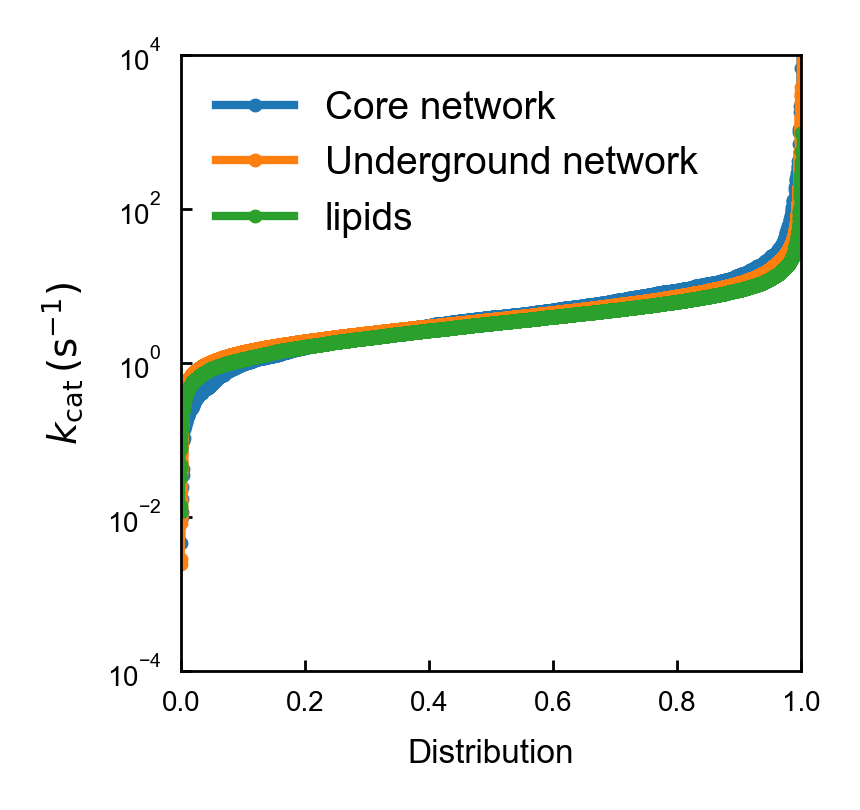

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# 设置通用参数 (Setting General Parameters)
plt.figure(figsize=(2, 2), dpi=400)
plt.rcParams.update({'font.size': 7})
plt.rcParams['font.family'] = 'Arial'

# 设置轴样式 (Setting Axis Styles)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)

# 绘制折线图 (Plotting Line Chart)
plt.plot(data_proportions_without_rxn_yeast8U, data_values_without_rxn_yeast8U, marker='.', markersize=3, linestyle='-', label='Core network')
plt.plot(data_proportions_with_rxn_yeast8U, data_values_with_rxn_yeast8U, marker='.', markersize=3, linestyle='-', label='Underground network')
plt.plot(data_proportions_with_rxn, data_values_with_rxn, marker='.', markersize=3, linestyle='-', label='lipids')

# 设置 x 轴标签 (Setting X-axis Labels)
plt.xlabel('Distribution',fontsize=6)
# plt.ylabel(r'$K_{m}$', fontsize=7)  # Km,K斜体，m下标
plt.ylabel(r'$k_{\mathrm{cat}}\,\left(\mathrm{s}^{-1}\right)$', fontsize=7)
plt.xlim(0, 1)
plt.ylim(0.0001, 10000)

# 设置坐标轴参数 (Setting Axis Parameters)
plt.yscale('log')
plt.grid(False)
plt.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)
plt.minorticks_off()  # 隐藏次级刻度
plt.legend(frameon=False,loc='upper left',fontsize=7)  # 添加图例
# plt.text(0.3, 40, r'$\mathit{P}$ value = 1e-5', fontsize=7, ha='center')

# 保存图形 (Save Figure)
# plt.savefig(yeast8U_km_predict_figure, dpi=400, bbox_inches='tight')

# 显示图形 (Display Figure)
plt.show()

# km

In [17]:
print(KM_pre_df_yeast8U.shape)
KM_pre_df_yeast8U = pd.concat([KM_pre_df_yeast8U[KM_pre_df_yeast8U['id'].str.contains('r_')].drop_duplicates(subset=['gene', 'sub']),
                       KM_pre_df_yeast8U[~KM_pre_df_yeast8U['id'].str.contains('r_')].drop_duplicates(subset=['gene', 'sub'])])
print(KM_pre_df_yeast8U.shape)

sce_seq_rxn_smiles_with_rxn_yeast8U = KM_pre_df_yeast8U[KM_pre_df_yeast8U['id'].str.contains('rxn')]
sce_seq_rxn_smiles_without_rxn_yeast8U = KM_pre_df_yeast8U[~KM_pre_df_yeast8U['id'].str.contains('rxn')]

data_values_with_rxn_yeast8U = np.sort(sce_seq_rxn_smiles_with_rxn_yeast8U["km"])
data_len_with_rxn_yeast8U = len(data_values_with_rxn_yeast8U)
data_proportions_with_rxn_yeast8U = np.arange(1, data_len_with_rxn_yeast8U + 1) / data_len_with_rxn_yeast8U

data_values_without_rxn_yeast8U = np.sort(sce_seq_rxn_smiles_without_rxn_yeast8U["km"])
data_len_without_rxn_yeast8U = len(data_values_without_rxn_yeast8U)
data_proportions_without_rxn_yeast8U = np.arange(1, data_len_without_rxn_yeast8U + 1) / data_len_without_rxn_yeast8U

(71443, 9)
(71443, 9)


In [18]:
print(KM_pre_df.shape)
Km_pre_df = pd.concat([KM_pre_df[KM_pre_df['id'].str.contains('r_')].drop_duplicates(subset=['gene', 'sub']),
                       KM_pre_df[~KM_pre_df['id'].str.contains('r_')].drop_duplicates(subset=['gene', 'sub'])])
print(Km_pre_df.shape)

(302664, 9)
(10477, 9)


In [19]:
sce_seq_rxn_smiles_with_rxn = Km_pre_df[Km_pre_df['id'].str.contains('rxn')]
sce_seq_rxn_smiles_without_rxn = Km_pre_df[~Km_pre_df['id'].str.contains('rxn')]

data_values_with_rxn = np.sort(sce_seq_rxn_smiles_with_rxn["km"])#median
data_len_with_rxn = len(data_values_with_rxn)
data_proportions_with_rxn = np.arange(1, data_len_with_rxn + 1) / data_len_with_rxn

data_values_without_rxn = np.sort(sce_seq_rxn_smiles_without_rxn["km"])#KM
data_len_without_rxn = len(data_values_without_rxn)
data_proportions_without_rxn = np.arange(1, data_len_without_rxn + 1) / data_len_without_rxn

In [20]:
from scipy import stats
t_statistic, p_value = stats.ttest_ind(data_values_with_rxn, data_values_without_rxn)
p_value

nan

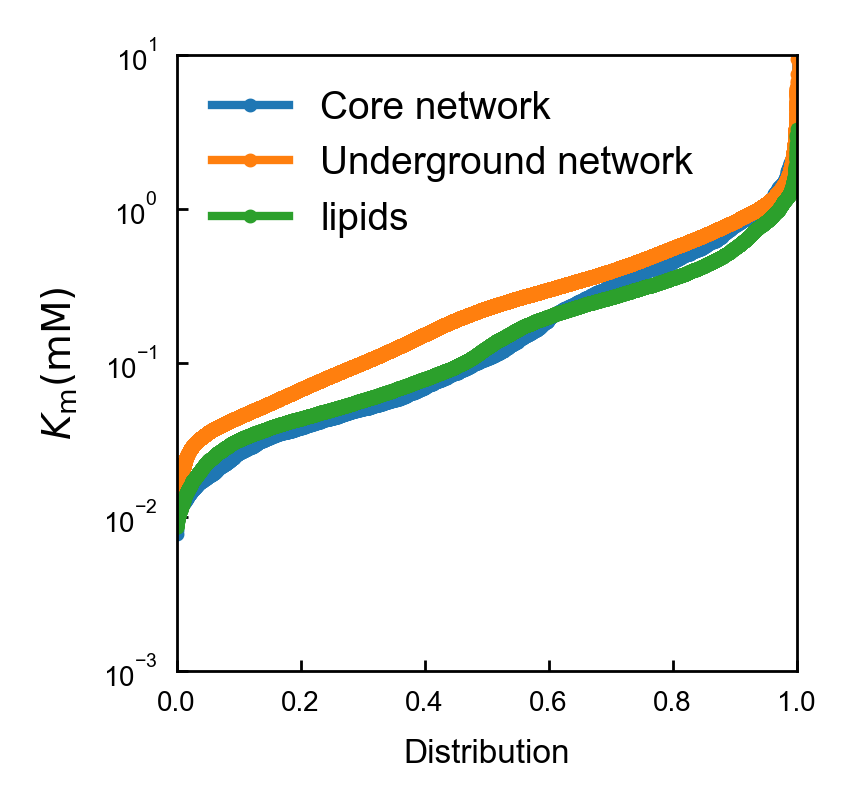

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 设置通用参数 (Setting General Parameters)
plt.figure(figsize=(2, 2), dpi=400)
plt.rcParams.update({'font.size': 7})
plt.rcParams['font.family'] = 'Arial'

# 设置轴样式 (Setting Axis Styles)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)

# 绘制折线图 (Plotting Line Chart)
plt.plot(data_proportions_without_rxn_yeast8U, data_values_without_rxn_yeast8U, marker='.', markersize=3, linestyle='-', label='Core network')
plt.plot(data_proportions_with_rxn_yeast8U, data_values_with_rxn_yeast8U, marker='.', markersize=3, linestyle='-', label='Underground network')
plt.plot(data_proportions_with_rxn, data_values_with_rxn, marker='.', markersize=3, linestyle='-', label='lipids')


# 设置 x 轴标签 (Setting X-axis Labels)
plt.xlabel('Distribution',fontsize=6)
# plt.ylabel(r'$K_{m}$', fontsize=7)  # Km,K斜体，m下标
plt.ylabel(r'$K_{\mathrm{m}}\mathrm{(mM)}$', fontsize=7)
plt.xlim(0, 1)
plt.ylim(0.001, 10)

# 设置坐标轴参数 (Setting Axis Parameters)
plt.yscale('log')
plt.grid(False)
plt.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)
plt.minorticks_off()  # 隐藏次级刻度
plt.legend(frameon=False,loc='upper left',fontsize=7)  # 添加图例
# plt.text(0.3, 0.7, r'$\mathit{P}$ value = 0.033', fontsize=7, ha='center')

# 保存图形 (Save Figure)
# plt.savefig(yeast8U_km_predict_figure, dpi=400, bbox_inches='tight')

# 显示图形 (Display Figure)
plt.show()

In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

In [ ]:
smiles_list = KM_pre_df['sub'].to_list()
enzyme_list = KM_pre_df['Sequence'].to_list()

import os
from tqdm import tqdm

for i in tqdm(range(10)):
    start_index = (i * len(smiles_list)) // 10
    end_index = ((i + 1) * len(smiles_list)) // 10
    smiles_subset = smiles_list[start_index:end_index]
    enzyme_subset = enzyme_list[start_index:end_index]
    file_name = f"./result/result_{i}.csv"
    if not os.path.exists(file_name):
        sequences = enzyme_subset
        Smiles = smiles_subset
        seq_vec = Seq_to_vec(sequences)
        print('Seq_to_vec done!')
        smiles_vec = smiles_to_vec(Smiles)
        print('smiles_to_vec done!')
        fused_vector = np.concatenate((smiles_vec, seq_vec), axis=1)
        ###### you should place downloaded model into this directory.
        # For kcat
        # with open('./unikp_model/UniKP for kcat.pkl', "rb") as f:
        #     model = pickle.load(f)
        # For Km
        with open('./unikp_model/UniKP for Km.pkl', "rb") as f:
            model = pickle.load(f)
        # For kcat/Km
        # with open('./unikp_model/UniKP for kcat_Km.pkl', "rb") as f:
        #     model = pickle.load(f)
        Pre_label = model.predict(fused_vector)
        Pre_label_pow = [math.pow(10, Pre_label[i]) for i in range(len(Pre_label))]
        print(len(Pre_label_pow))
        res = pd.DataFrame({'sequences': sequences, 'Smiles': Smiles, 'Pre_label': Pre_label_pow})
        res.to_csv(file_name, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]Some weights of the model checkpoint at ./prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.16.layer.2.DenseReluDense.wo.weight', 'decoder.block.5.layer.0.layer_norm.weight', 'decoder.block.17.layer.1.EncDecAttention.k.weight', 'decoder.block.16.layer.0.SelfAttention.o.weight', 'decoder.block.11.layer.1.EncDecAttention.k.weight', 'decoder.block.8.layer.1.EncDecAttention.o.weight', 'decoder.block.22.layer.0.SelfAttention.k.weight', 'decoder.block.19.layer.2.layer_norm.weight', 'decoder.block.21.layer.1.EncDecAttention.k.weight', 'decoder.block.13.layer.0.SelfAttention.v.weight', 'decoder.block.5.layer.1.EncDecAttention.v.weight', 'decoder.block.7.layer.2.DenseReluDense.wi.weight', 'decoder.block.14.layer.0.SelfAttention.k.weight', 'decoder.block.20.layer.2.DenseReluDense.wo.weight', 'decoder.block.10.layer.0.SelfAttention.q.weight', 'decoder.block.9.layer.1.EncDecAttention.v.weight', 'decoder.block.2.layer.1.EncDecA

KeyboardInterrupt: 

In [ ]:
break

In [ ]:
Kcat_pre_pd = KM_pre_df.loc[0:1000,:]

In [ ]:
sequences = Kcat_pre_pd['Sequence'].to_list()
Smiles = Kcat_pre_pd['sub'].to_list()
seq_vec = Seq_to_vec(sequences)
smiles_vec = smiles_to_vec(Smiles)
fused_vector = np.concatenate((smiles_vec, seq_vec), axis=1)

###### you should place downloaded model into this directory.
# For kcat
# with open('./unikp_model/UniKP for kcat.pkl', "rb") as f:
#     model = pickle.load(f)
# For Km
with open('./unikp_model/UniKP for Km.pkl', "rb") as f:
    model = pickle.load(f)
# For kcat/Km
# with open('./unikp_model/UniKP for kcat_Km.pkl', "rb") as f:
#     model = pickle.load(f)

Pre_label = model.predict(fused_vector)
Pre_label_pow = [math.pow(10, Pre_label[i]) for i in range(len(Pre_label))]
print(len(Pre_label_pow))
res = pd.DataFrame({'sequences': sequences, 'Smiles': Smiles, 'Pre_label': Pre_label_pow})
res.to_excel('./yeast8U_unikp_km_result.csv')
res

Some weights of the model checkpoint at ./prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.15.layer.1.layer_norm.weight', 'decoder.block.8.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.1.EncDecAttention.k.weight', 'decoder.block.17.layer.1.layer_norm.weight', 'decoder.block.16.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.12.layer.1.EncDecAttention.q.weight', 'decoder.block.14.layer.1.EncDecAttention.k.weight', 'decoder.block.21.layer.2.DenseReluDense.wi.weight', 'decoder.block.22.layer.1.layer_norm.weight', 'decoder.block.1.layer.1.layer_norm.weight', 'decoder.block.1.layer.1.EncDecAttention.v.weight', 'decoder.block.22.layer.1.EncDecAttention.q.weight', 'decoder.block.19.layer.1.EncDecAttention.v.weight', 'decoder.block.15.layer.2.DenseReluDense.wi.weight', 'decoder.block.12.layer.2.DenseReluDense.wo.weight', 'decoder.block.18.layer.0.layer_norm.weight', 'decoder.block.14.layer.2.layer_norm.

KeyboardInterrupt: 